<a href="https://colab.research.google.com/github/canmizrakli/TDSP.Net/blob/main/TDSP_YOLO_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLO-based Task-driven Visual Saliency Prediction



This notebook demonstrates a complete workflow for building a YOLO-based architecture for task-based visual saliency prediction.

**Dataset Structure**  
Your dataset (stored on Google Drive at `/content/drive/MyDrive/TDSP/Task-based-eye-fixation-dataset_1024x768`) should be organized as follows:



**Task Definitions**  
- **task1** → free view  
- **task2** → count people  
- **task3** → detect the emotion  
- **task4** → identify the action

The notebook includes:  
- Paired data augmentation  
- A YOLO-based backbone (pre-trained)  
- A TaskEncoder using Sentence-BERT for rich task embeddings  
- A saliency-specific loss function

## Preprocessing

In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 2. Install Dependencies
!pip install --upgrade torch torchvision einops
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

### Data Augmentation & Paired Transforms

In [3]:
import random
import torchvision.transforms.functional as TF  # Use TF to avoid conflicts with torch.nn.functional

# Paired random horizontal flip
class PairedRandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, sal):
        if random.random() < self.p:
            img = TF.hflip(img)
            sal = TF.hflip(sal)
        return img, sal

# Paired random rotation
class PairedRandomRotation:
    def __init__(self, degrees=10):
        self.degrees = degrees

    def __call__(self, img, sal):
        angle = random.uniform(-self.degrees, self.degrees)
        img = TF.rotate(img, angle)
        sal = TF.rotate(sal, angle)
        return img, sal

## Dataset Definition

In [4]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

# Define task mapping from folder names to descriptive labels.
task_mapping = {
    "task1": "free view",
    "task2": "count people",
    "task3": "detect the emotion",
    "task4": "identify the action"
}

class TaskSaliencyDataset(Dataset):
    def __init__(self, data_root, task_mapping, transform=None, saliency_transform=None, paired_transforms=None):
        """
        data_root: Root path of the dataset.
        task_mapping: Dictionary mapping task folder names (e.g., "task1") to task descriptions.
        transform: Transforms for stimuli images (e.g., resizing, ToTensor).
        saliency_transform: Transforms for saliency maps.
        paired_transforms: List of callables that apply the same random transform to both stimuli and saliency.
        """
        self.data_root = data_root
        self.task_mapping = task_mapping
        self.transform = transform
        self.saliency_transform = saliency_transform
        self.paired_transforms = paired_transforms

        self.tasks = list(task_mapping.keys())
        self.samples = []

        # Iterate over each task folder and gather samples
        for task in self.tasks:
            task_folder = os.path.join(data_root, task)
            fdm_folder = os.path.join(task_folder, "fdm")
            fdm_files = glob.glob(os.path.join(fdm_folder, "*.png"))
            for fdm_file in fdm_files:
                filename = os.path.basename(fdm_file)
                base = os.path.splitext(filename)[0]
                # Look for corresponding stimuli image (.jpg or .png)
                stimuli_path_jpg = os.path.join(data_root, "stimuli", base + ".jpg")
                stimuli_path_png = os.path.join(data_root, "stimuli", base + ".png")
                if os.path.exists(stimuli_path_jpg):
                    stimuli_path = stimuli_path_jpg
                elif os.path.exists(stimuli_path_png):
                    stimuli_path = stimuli_path_png
                else:
                    continue
                self.samples.append((stimuli_path, fdm_file, task))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        stimuli_path, fdm_path, task = self.samples[idx]
        stimuli_img = Image.open(stimuli_path).convert("RGB")
        fdm_img = Image.open(fdm_path).convert("L")

        if self.transform:
            stimuli_img = self.transform(stimuli_img)
        if self.saliency_transform:
            fdm_img = self.saliency_transform(fdm_img)
        else:
            fdm_img = T.ToTensor()(fdm_img)

        # Apply paired transforms if defined
        if self.paired_transforms is not None:
            for t in self.paired_transforms:
                stimuli_img, fdm_img = t(stimuli_img, fdm_img)

        task_description = self.task_mapping[task]

        return {
            "stimuli": stimuli_img,
            "fdm": fdm_img,
            "task": task,
            "task_description": task_description
        }

# Define transforms
input_transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
])
saliency_transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
])
paired_transforms = [
    PairedRandomHorizontalFlip(p=0.5),
    PairedRandomRotation(degrees=10)
]

# Path to your dataset (adjust the path if needed)
DATA_PATH = "/content/drive/MyDrive/TDSP/Task-based-eye-fixation-dataset_1024x768"

dataset = TaskSaliencyDataset(
    data_root=DATA_PATH,
    task_mapping=task_mapping,
    transform=input_transform,
    saliency_transform=saliency_transform,
    paired_transforms=paired_transforms
)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

print("Tasks found:", dataset.tasks)
print("Number of samples:", len(dataset))


Tasks found: ['task1', 'task2', 'task3', 'task4']
Number of samples: 1968


## Model Components

Imports

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from ultralytics import YOLO
from sentence_transformers import SentenceTransformer

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


###1. Pre-trained YOLO Backbone


A YOLO (YOLOv5) model with its final detection layers removed, leaving only the feature extraction layers. This part extracts deep visual features from the input image.

In [6]:
class YOLOBackbone(nn.Module):
    def __init__(self, model_name="yolov5s.pt"):
        super().__init__()
        # Load pre-trained YOLO model by specifying the weight file
        self.yolo_model = YOLO(model_name)
        # Retain only the feature extraction layers (adjust slicing as needed)
        self.feature_extractor = self.yolo_model.model.model[:10]

    def forward(self, x):
        return self.feature_extractor(x)

    def train(self, mode=True):
        # Override train method to only set training mode on the feature extractor
        self.feature_extractor.train(mode)
        return self

### 2. Feature Pyramid Network (FPN)



A simple FPN-like module that reduces the channel dimension from (e.g.) 512 to 128. It takes the complex features from the YOLO backbone and simplifies them.This helps unify the feature map so it can be fused with the task embedding.

In [7]:
class SimpleFPN(nn.Module):
    def __init__(self, in_channels=512, out_channels=128):
        super().__init__()
        self.conv_out = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, backbone_feats):
        x = self.conv_out(backbone_feats)
        return x

### 3. Task Encoder



Uses Sentence-BERT to convert a short text description (e.g., “count people”) into a dense embedding (e.g., 64 dimensions). This embedding captures semantic information about the task.

In [8]:
class TaskEncoder(nn.Module):
    def __init__(self, output_dim=64):
        super().__init__()
        self.text_encoder = SentenceTransformer('all-MiniLM-L6-v2')
        # Sentence-BERT outputs 384-dimensional embeddings; reduce to output_dim.
        self.linear = nn.Linear(384, output_dim)

    def forward(self, task_descriptions):
        # Process a list of task description strings
        embeddings = self.text_encoder.encode(task_descriptions, convert_to_tensor=True)
        embeddings = self.linear(embeddings)
        return F.relu(embeddings)

###4. Transformer Fusion Module



  This module fuses visual features with the task description, enabling the model to integrate contextual task information with the image’s visual representation.

- **How it works**  
  - **Flattening**  
    The two-dimensional feature map produced by the YOLO backbone and FPN is reshaped into a one-dimensional sequence of tokens. This process is analogous to decomposing an image into a series of small patches or segments.

  - **Adding the Task Token**  
    The task embedding, generated by the Task Encoder, is projected into a compatible feature space and then prepended to the sequence as an extra token. This token injects task-specific context into the sequence.

  - **Processing**  
    The combined sequence—comprising both the visual tokens and the task token—is processed by a transformer encoder. The encoder’s self-attention mechanism learns to correlate and integrate information from both the image details and the task description.

  - **Reshaping Back**  
    After processing, the enriched sequence is reshaped back into a two-dimensional feature map. This map, now infused with task-aware information, is used by the saliency decoder to generate the final saliency map.

In [9]:
class TransformerFusion(nn.Module):
    def __init__(self, d_model=128, nhead=4, num_layers=1, task_embed_dim=64):
        super().__init__()
        self.query_proj = nn.Linear(task_embed_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, vision_feats, task_embed):
        B, C, H, W = vision_feats.shape
        vision_seq = rearrange(vision_feats, 'b c h w -> (h w) b c')
        task_query = self.query_proj(task_embed)
        task_query = rearrange(task_query, 'b d -> 1 b d')
        fused_seq = torch.cat([task_query, vision_seq], dim=0)
        encoded_seq = self.transformer_encoder(fused_seq)
        encoded_vision = encoded_seq[1:, :, :]
        encoded_vision = rearrange(encoded_vision, '(h w) b c -> b c h w', h=H, w=W)
        return encoded_vision

###5. Saliency Decoder



A small decoder (convolutional layers + batch normalization + ReLU) that converts the fused feature map into a single-channel saliency map. A final sigmoid squashes values into the [0,1] range.

In [10]:
class SaliencyDecoder(nn.Module):
    def __init__(self, in_channels=128):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return torch.sigmoid(x)

###6. The Complete Model: YOLOTaskSaliencyModel

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 6.6 Complete Model: YOLOTaskSaliencyModel
class YOLOTaskSaliencyModel(nn.Module):
    def __init__(self, task_embed_dim=64, vision_dim=128, nhead=4, num_layers=1):
        super().__init__()
        self.backbone = YOLOBackbone(model_name="yolov5s.pt")
        self.fpn = SimpleFPN(in_channels=512, out_channels=128)  # Updated here
        self.task_encoder = TaskEncoder(output_dim=task_embed_dim)
        self.transformer_fusion = TransformerFusion(d_model=vision_dim, nhead=nhead,
                                                    num_layers=num_layers, task_embed_dim=task_embed_dim)
        self.saliency_decoder = SaliencyDecoder(in_channels=vision_dim)

    def forward(self, images, task_descriptions):
        feat = self.backbone(images)          # Output shape: [B, 512, H/?, W/?]
        feat = self.fpn(feat)                 # Now shape becomes [B, 128, H/?, W/?]
        task_embed = self.task_encoder(task_descriptions)  # [B, task_embed_dim]
        fused_feat = self.transformer_fusion(feat, task_embed)  # [B, 128, H/?, W/?]
        saliency_map = self.saliency_decoder(fused_feat)  # [B, 1, H/?, W/?]
        saliency_map_upsampled = F.interpolate(
            saliency_map,
            size=(images.shape[2], images.shape[3]),  # match input's H, W
            mode='bilinear',
            align_corners=False
        )
        return saliency_map_upsampled

## Loss Function

Saliency-Specific Loss Function

A custom loss combining KL Divergence and (1 - Pearson’s Correlation Coefficient). Encourages the predicted map to match the ground-truth saliency distribution while being correlated with it spatially.

In [12]:
class SaliencyLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        """
        alpha: Weight for the KL Divergence term.
        beta: Weight for (1 - Pearson's Correlation Coefficient) term.
        """
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, pred, gt):
        # Ensure shape is [B, H, W]
        if len(pred.shape) == 4:
            pred = pred[:, 0]
        if len(gt.shape) == 4:
            gt = gt[:, 0]

        B, H, W = pred.shape
        pred = pred.reshape(B, -1)
        gt = gt.reshape(B, -1)
        eps = 1e-12
        pred_norm = pred / (pred.sum(dim=1, keepdim=True) + eps)
        gt_norm = gt / (gt.sum(dim=1, keepdim=True) + eps)

        # KL Divergence: sum(gt * log(gt/pred))
        kl = (gt_norm * torch.log((gt_norm + eps) / (pred_norm + eps))).sum(dim=1).mean()

        # Pearson's Correlation Coefficient (CC)
        pred_mean = pred.mean(dim=1, keepdim=True)
        gt_mean = gt.mean(dim=1, keepdim=True)
        numerator = ((pred - pred_mean) * (gt - gt_mean)).sum(dim=1)
        denominator = torch.sqrt(((pred - pred_mean)**2).sum(dim=1) * ((gt - gt_mean)**2).sum(dim=1)) + eps
        cc = (numerator / denominator).mean()

        loss = self.alpha * kl + self.beta * (1 - cc)
        return loss

## Training

### Initial training that calculates loss per batch

In [13]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
num_epochs = 15

model = YOLOTaskSaliencyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = SaliencyLoss(alpha=1.0, beta=1.0)

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 299MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [14]:
print(model)

YOLOTaskSaliencyModel(
  (backbone): YOLOBackbone(
    (yolo_model): YOLO(
      (model): DetectionModel(
        (model): Sequential(
          (0): Conv(
            (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (1): Conv(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (2): C3(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): 

In [15]:
print("Batch size:", dataloader.batch_size)

Batch size: 32


In [16]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, batch_data in enumerate(dataloader):
        images = batch_data["stimuli"].to(device)   # [B, 3, H, W]
        fdm = batch_data["fdm"].to(device)           # [B, 1, H, W]
        # Task descriptions are returned as a list of strings
        task_descs = batch_data["task_description"]

        optimizer.zero_grad()
        pred_saliency = model(images, task_descs)    # Forward pass using task descriptions
        loss = criterion(pred_saliency, fdm)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % 30 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}] Loss: {loss.item():.4f}", flush=True)
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}", flush=True)


Epoch [1/15], Batch [30/62] Loss: 2.3169
Epoch [1/15], Batch [60/62] Loss: 2.1598
Epoch [1/15] Average Loss: 2.4057
Epoch [2/15], Batch [30/62] Loss: 2.2469
Epoch [2/15], Batch [60/62] Loss: 2.0653
Epoch [2/15] Average Loss: 2.1617
Epoch [3/15], Batch [30/62] Loss: 2.0116
Epoch [3/15], Batch [60/62] Loss: 2.0687
Epoch [3/15] Average Loss: 2.0639
Epoch [4/15], Batch [30/62] Loss: 2.0088
Epoch [4/15], Batch [60/62] Loss: 1.9401
Epoch [4/15] Average Loss: 1.9859
Epoch [5/15], Batch [30/62] Loss: 1.8386
Epoch [5/15], Batch [60/62] Loss: 1.9500
Epoch [5/15] Average Loss: 1.9129
Epoch [6/15], Batch [30/62] Loss: 1.7681
Epoch [6/15], Batch [60/62] Loss: 1.7642
Epoch [6/15] Average Loss: 1.8560
Epoch [7/15], Batch [30/62] Loss: 1.8285
Epoch [7/15], Batch [60/62] Loss: 1.7650
Epoch [7/15] Average Loss: 1.8068
Epoch [8/15], Batch [30/62] Loss: 1.7474
Epoch [8/15], Batch [60/62] Loss: 1.6540
Epoch [8/15] Average Loss: 1.7608
Epoch [9/15], Batch [30/62] Loss: 1.7976
Epoch [9/15], Batch [60/62] Los

In [17]:
# Full Dataset Loss Calculation Cell

import torch

# Make sure your model is in evaluation mode
model.eval()

# Lists to accumulate predictions and ground truths
all_preds = []
all_gts = []

# Iterate through the dataloader and move predictions and ground truths to CPU
with torch.no_grad():
    for batch_data in dataloader:
        images = batch_data["stimuli"].to(device)  # [B, 3, H, W]
        gts = batch_data["fdm"].to(device)           # [B, 1, H, W]
        task_descs = batch_data["task_description"]  # list of task strings

        # Forward pass through the model
        preds = model(images, task_descs)  # [B, 1, H, W]

        # Append predictions and ground truths to lists after moving to CPU
        all_preds.append(preds.cpu())
        all_gts.append(gts.cpu())

# Concatenate all predictions and ground truths
full_preds = torch.cat(all_preds, dim=0)
full_gts = torch.cat(all_gts, dim=0)

# Move the full tensors back to the device (if required) for loss computation
full_loss = criterion(full_preds.to(device), full_gts.to(device))
print(f"Full Dataset Loss: {full_loss.item():.4f}")

Full Dataset Loss: 1.4903


### Alternative training that calculates loss on the whole dataset

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
num_epochs = 5

model = YOLOTaskSaliencyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = SaliencyLoss(alpha=1.0, beta=1.0)

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
print("Batch size:", dataloader.batch_size)

for epoch in range(num_epochs):
    model.train()
    all_preds = []
    all_gts = []
    total_batches = len(dataloader)

    for batch_idx, batch_data in enumerate(dataloader):
        images = batch_data["stimuli"].to(device)   # [B, 3, H, W]
        gts = batch_data["fdm"].to(device)            # [B, 1, H, W]
        task_descs = batch_data["task_description"]   # list of strings

        # Forward pass for the batch
        preds = model(images, task_descs)             # [B, 1, H, W]

        # Accumulate predictions and ground truths
        all_preds.append(preds)
        all_gts.append(gts)

        # Every 30 batches, compute and print the running loss on the accumulated data so far
        if (batch_idx + 1) % 30 == 0:
            partial_preds = torch.cat(all_preds, dim=0)
            partial_gts = torch.cat(all_gts, dim=0)
            partial_loss = criterion(partial_preds, partial_gts)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{total_batches}] Running Loss: {partial_loss.item():.4f}", flush=True)

    # At the end of the epoch, compute the full loss over the entire dataset (epoch)
    full_preds = torch.cat(all_preds, dim=0)
    full_gts = torch.cat(all_gts, dim=0)
    loss = criterion(full_preds, full_gts)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Full Dataset Loss: {loss.item():.4f}", flush=True)

Batch size: 8
Epoch [1/5], Batch [30/246] Running Loss: 3.2159
Epoch [1/5], Batch [60/246] Running Loss: 3.2169
Epoch [1/5], Batch [90/246] Running Loss: 3.1975
Epoch [1/5], Batch [120/246] Running Loss: 3.1959


OutOfMemoryError: CUDA out of memory. Tried to allocate 676.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 378.12 MiB is free. Process 171588 has 14.37 GiB memory in use. Of the allocated memory 14.15 GiB is allocated by PyTorch, and 70.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### 3rd Alternative that uses scheduled decreasing learning rate

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
num_epochs = 15

model = YOLOTaskSaliencyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = SaliencyLoss(alpha=1.0, beta=1.0)

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 333MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
print("Batch size:", dataloader.batch_size)

from torch.optim.lr_scheduler import MultiStepLR

optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = MultiStepLR(optimizer, milestones=[5, 10], gamma=0.1)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, batch_data in enumerate(dataloader):
        images = batch_data["stimuli"].to(device)
        fdm = batch_data["fdm"].to(device)
        task_descs = batch_data["task_description"]

        optimizer.zero_grad()
        pred_saliency = model(images, task_descs)
        loss = criterion(pred_saliency, fdm)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % 30 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}] Loss: {loss.item():.4f}", flush=True)

    scheduler.step()  # Adjusts learning rate according to milestones
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}", flush=True)

Batch size: 32


KeyboardInterrupt: 

### Save the model

In [18]:
import os

# Path to your models folder inside TDSP
models_dir = "/content/drive/MyDrive/TDSP/models"
# Create the folder if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Full path where you want to save your model
save_path = os.path.join(models_dir, "yolo_task_saliency_model_v15epoch_21_04_2025.pth")

# Save the model state dictionary
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/TDSP/models/yolo_task_saliency_model_v15epoch_21_04_2025.pth


## Inference


Evaluation & Visualization

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



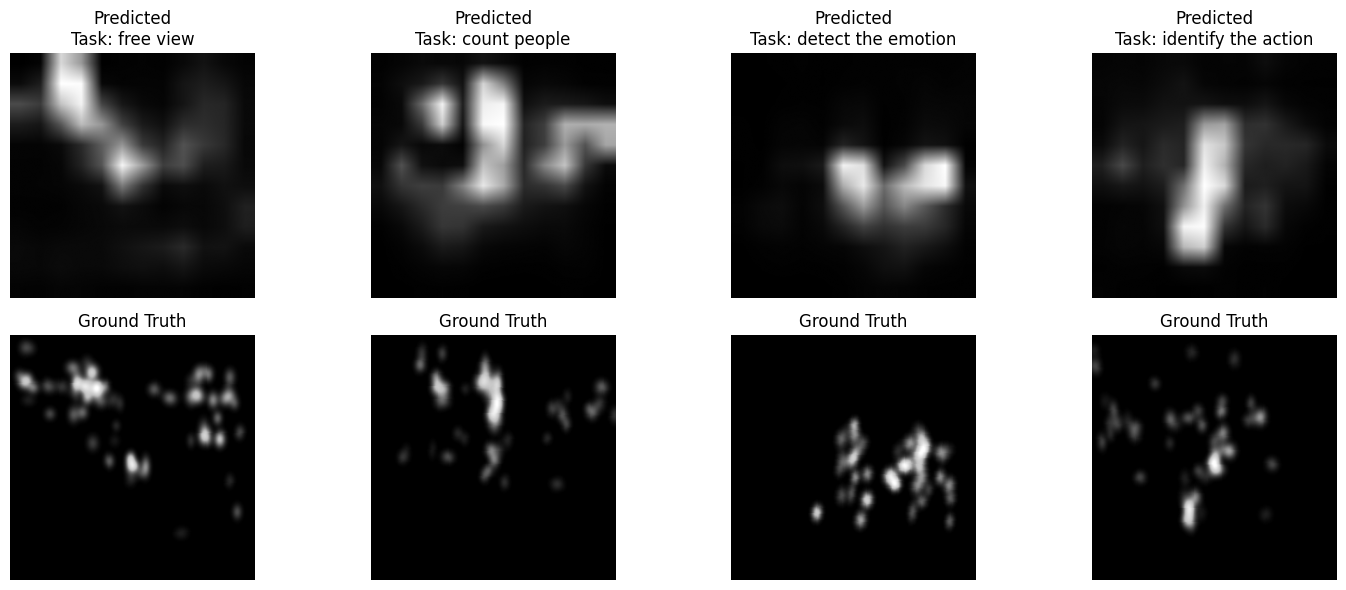

In [20]:
import torch
import matplotlib.pyplot as plt

# 1. Define the tasks you want to visualize (one sample per task).
tasks_to_show = ["task1", "task2", "task3", "task4"]

# 2. Gather exactly one sample per task from your dataset.
samples = []
for task_name in tasks_to_show:
    # Find the first sample in the dataset that matches this task.
    for i in range(len(dataset)):
        sample = dataset[i]  # sample is a dict with keys: "stimuli", "fdm", "task", "task_description"
        if sample["task"] == task_name:
            samples.append(sample)
            break

# 3. Convert these samples into a single batch.
images_list = [s["stimuli"] for s in samples]          # Each is [3, H, W] (a torch.Tensor).
fdm_list = [s["fdm"] for s in samples]                 # Each is [1, H, W].
task_descs = [s["task_description"] for s in samples]  # Each is a string.

images_batch = torch.stack(images_list, dim=0)  # shape: [4, 3, H, W]
fdm_batch = torch.stack(fdm_list, dim=0)        # shape: [4, 1, H, W]

# 4. Load your model from Drive (make sure YOLOTaskSaliencyModel is defined).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLOTaskSaliencyModel().to(device)

saved_model_path = "/content/drive/MyDrive/TDSP/models/yolo_task_saliency_model_v15epoch_21_04_2025.pth"
model.load_state_dict(torch.load(saved_model_path, map_location=device))
model.eval()

# 5. Move your batch to the same device as the model.
images_batch = images_batch.to(device)
fdm_batch = fdm_batch.to(device)

# 6. Run inference on this 4-sample batch.
with torch.no_grad():
    pred_saliency = model(images_batch, task_descs)  # [4, 1, H, W]

# 7. Convert predictions and ground truth to NumPy arrays for plotting.
pred_saliency_np = pred_saliency.cpu().numpy()  # shape: [4, 1, H, W]
fdm_np = fdm_batch.cpu().numpy()                # shape: [4, 1, H, W]

# 8. Plot them in a 2×4 grid (top row = predictions, bottom row = ground truth).
num_samples = len(samples)  # should be 4
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

for i in range(num_samples):
    # Show predicted saliency map (in grayscale)
    axes[0, i].imshow(pred_saliency_np[i, 0], cmap='gray')
    axes[0, i].set_title(f"Predicted\nTask: {task_descs[i]}")
    axes[0, i].axis('off')

    # Show ground-truth saliency map
    axes[1, i].imshow(fdm_np[i, 0], cmap='gray')
    axes[1, i].set_title("Ground Truth")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Evaluate model performance

In [ ]:
import torch

def correlation_coefficient(pred, gt):
    """
    Computes Pearson's Correlation Coefficient between two saliency maps.
    pred, gt: torch.Tensor of shape [H, W], assumed float in [0,1].
    Returns a scalar tensor (higher is better).
    """
    # Flatten to 1D
    pred_flat = pred.view(-1)
    gt_flat = gt.view(-1)

    pred_mean = pred_flat.mean()
    gt_mean = gt_flat.mean()

    numerator = ((pred_flat - pred_mean) * (gt_flat - gt_mean)).sum()
    denominator = torch.sqrt(((pred_flat - pred_mean)**2).sum() * ((gt_flat - gt_mean)**2).sum()) + 1e-12

    return numerator / denominator

def kl_divergence(pred, gt):
    """
    Computes KL Divergence between two saliency maps treated as probability distributions.
    pred, gt: torch.Tensor of shape [H, W], assumed float in [0,1].
    Returns a scalar tensor (lower is better).
    """
    eps = 1e-12
    # Normalize so each sums to 1
    pred_norm = pred / (pred.sum() + eps)
    gt_norm = gt / (gt.sum() + eps)

    return (gt_norm * torch.log((gt_norm + eps) / (pred_norm + eps))).sum()


In [ ]:
def evaluate_saliency_model(model, dataloader, device):
    model.eval()
    cc_scores = []
    kld_scores = []

    with torch.no_grad():
        for batch_data in dataloader:
            images = batch_data["stimuli"].to(device)  # [B, 3, H, W]
            fdm = batch_data["fdm"].to(device)         # [B, 1, H, W]
            task_descs = batch_data["task_description"]

            # 1. Forward pass
            pred_saliency = model(images, task_descs)  # [B, 1, H, W]

            # 2. For each item in the batch
            for i in range(images.size(0)):
                pred_map = pred_saliency[i, 0]  # shape [H, W]
                gt_map = fdm[i, 0]             # shape [H, W]

                # 3. Compute metrics
                cc = correlation_coefficient(pred_map, gt_map)
                kld = kl_divergence(pred_map, gt_map)

                cc_scores.append(cc.item())
                kld_scores.append(kld.item())

    # 4. Compute averages
    avg_cc = sum(cc_scores) / len(cc_scores) if cc_scores else 0
    avg_kld = sum(kld_scores) / len(kld_scores) if kld_scores else 0

    print(f"Average CC: {avg_cc:.4f}")
    print(f"Average KLD: {avg_kld:.4f}")
    return avg_cc, avg_kld

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
avg_cc, avg_kld = evaluate_saliency_model(model, dataloader, device)


In [22]:
!pip install nbstripout
!nbstripout --install
!nbstripout TDSP_YOLO_v3.ipynb

fatal: --local can only be used inside a git repository
Installation failed: not a git repository!
Could not strip 'TDSP_YOLO_v3.ipynb': file not found


In [24]:
import json

NOTEBOOK_PATH = "/content/drive/MyDrive/Colab Notebooks/TDSP_YOLO_v2-8_clean.ipynb"  # or whatever your .ipynb is called

# 1) Load it
with open(NOTEBOOK_PATH, "r", encoding="utf-8") as f:
    nb = json.load(f)

# 2) Remove any top‑level metadata.widgets
nb.get("metadata", {}).pop("widgets", None)

# 3) Remove any cell‑level metadata.widgets
for cell in nb.get("cells", []):
    cell.get("metadata", {}).pop("widgets", None)

# 4) Write it back
with open(NOTEBOOK_PATH, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=1)

print(f"Stripped all metadata.widgets from {NOTEBOOK_PATH}")


Stripped all metadata.widgets from /content/drive/MyDrive/Colab Notebooks/TDSP_YOLO_v2-8_clean.ipynb
